In [1]:
import os 
from pathlib import Path
from import_file import import_file

import numpy as np
import statsmodels.api  as sm
from statsmodels.sandbox.regression.gmm import GMM

#jax_aux_file_jitted_25_01_2023 = import_file(os.path.join(Path(os.getcwd()).parent,'jax_aux_file_jitted_25_01_2023.py'))
def corr_np(s,envelope,envelope_params):
    """return overlap area (i.e. correlation) Corr(X_t,X_{t+s}). these are equivalent because the area of the 
    ambit set is normalised to 1. s >0"""

    assert envelope in ['gamma','gamma_H']
        
    if envelope == 'gamma':
        H,delta = envelope_params
        area = (1+s/delta)**(-H)
        

    return area

In [2]:
def get_initial_value_for_1_param_trawl_function(tau_ ,values_,envelope,aux_param):
    assert len(values_.shape) < 2
    
    emp_corr_at_lag_1 =  np.array(sm.tsa.stattools.acf(all_values_[0],nlags =1))[[1]]
    
   
    if envelope == 'gamma_H':
        assert isinstance(aux_param,tuple) and len(aux_param) == 1
        delta = aux_param[0]
        return - np.log(emp_corr_at_lag_1) / np.log(1+ tau_/delta)

def corr_np_GMM_gamma_H(delta_):
    
    
    def func__(s,envelope,envelope_params):
        
        assert envelope == 'gamma_H'  
        return  (1+s/delta_)**(-envelope_params[0])
    
    return func__
    
    

class GMMGamma2(GMM):
    def momcond(self, params):
        envelope_params = params
        g = []         
        endog = self.endog

        tau = self.tau
        lags_list= self.lags_list
        envelope = self.envelope


        for index in range(len(lags_list)):
            lag_to_use = lags_list[index]
            tau_to_use = tau * lag_to_use
            empirical_acf = (endog[:-lag_to_use] * endog[lag_to_use:] - endog.mean()**2) / endog.var()
            error_to_add  = empirical_acf - corr_np(tau_to_use,envelope,envelope_params) 
            g.append(error_to_add)

        min_length = min([len(i) for i in g])
        #print(1)
        h = np.column_stack([error[:min_length] for error in g])
        #print(2)
        return h

In [3]:
#############CHANGE THE FOLDER NAME ###########
folder_to_acces = 'results2'
###############################################
parameters___ = import_file(os.path.join(os.getcwd(),folder_to_acces,'parameters'))
lags_list             = parameters___.lags_list
levy_seed             = parameters___.levy_seed
tau                   =  float(parameters___.tau)
envelope              = parameters___.envelope    #envelope  is one of  ['exponential','gamma','ig']
if envelope == 'gamma_H':
    envelope = 'gamma'
n_values              = parameters___.n_values
TRUE_ENVELOPE_PARAMS  = parameters___.TRUE_ENVELOPE_PARAMS
#DELTA                 = parameters___.TRUE_ENVELOPE_PARAMS[1]


all_values_ = np.load(os.path.join(os.getcwd(),folder_to_acces,'values.npy'))

        
if envelope == 'gamma':
    input_ = input('nr params to be fitted, 1 or 2 \n')
    
    if input_ == '1':
        #if we only fit H, use the true value for delta
        envelope = 'gamma_H'
        corr_np = corr_np_GMM_gamma_H(parameters___.TRUE_ENVELOPE_PARAMS[1]) 
        
    elif input_ == '2':
        #if we fit both H and delta
        starting_point = input('starting points for the envelope params is separated by commas ')
        starting_point = np.array(tuple(float(x) for x in starting_point.split(",")))
        
    else:
        raise ValueError

print(envelope)

nr params to be fitted, 1 or 2 
1
gamma_H


#### if it's a 2 parameter envelope, start from a fixed point; if it's a 1 parameter envelope, start from the estimator using the correlation at lag 1

In [4]:
d = dict()

for n_to_use in n_values: 
    for lags_to_use in lags_list:

        l = []
        
        for simulation_number in range(len(all_values_)):
            
            values_to_use = all_values_[simulation_number,:n_to_use].copy()
            
            if envelope == 'exponential':
                starting_point = get_initial_value_for_1_param_trawl_function(tau_ = tau ,values_ = values_to_use.copy(),
                                                            envelope = envelope, aux_param = None)
                
                
            elif envelope =='gamma_H' and input_ == '1':
                starting_point = get_initial_value_for_1_param_trawl_function(tau_ = tau ,values_ = values_to_use.copy(),
                                                            envelope = envelope, aux_param = TRUE_ENVELOPE_PARAMS[1:])
                #print(starting_point)
        
            
            z                = np.ones([len(values_to_use), len(lags_to_use)])
            model            = GMMGamma2(values_to_use, z.copy(), z)
            model.tau        = tau
            model.lags_list  = lags_to_use  #this should be the list of lags, i.e. lags_to_use, not lags_list which is a list of lists
            model.trawl_path = values_to_use
            model.envelope   = envelope
    
            res = model.fit(starting_point,  optim_method='bfgs')
            l.append(res)
        d[(lags_to_use,n_to_use)]  = l
        #%%capture capt


Optimization terminated successfully.
         Current function value: 0.003056
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000563
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000563
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000563
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001153
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000581
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000361
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000361
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000361
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000726
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.011942
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001803
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001803
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001803
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.015438
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002447
         Iterations: 4
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010776
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001401
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001401
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001401
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002544
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002544
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002544
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000964
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000325
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000325
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.009838
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001045
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001045
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010287
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002259
         Iterations: 4
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001388
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001388
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001388
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001764
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000491
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000491
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.015689
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002637
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002637
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002637
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000489
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000311
         Iterations: 3
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000445
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000445
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001285
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient

Optimization terminated successfully.
         Current function value: 0.000599
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000599
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009508
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001498
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001498
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001498
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001367
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000632
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000131
         Iterations: 3
         Function evaluations: 6
         Gradient e

         Current function value: 0.000051
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000051
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000268
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated 

Optimization terminated successfully.
         Current function value: 0.000203
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000648
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000197
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000197
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000197
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000355
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002689
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000471
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000471
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000471
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002059
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000320
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001523
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001523
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001523
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.007276
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000863
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000863
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000309
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000309
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000514
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000238
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000238
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000238
         Iterations: 0
         Function evaluations: 1
         Gradient

Optimization terminated successfully.
         Current function value: 0.002901
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000611
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000611
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000611
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000702
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000171
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000417
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000290
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002190
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000283
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000126
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004744
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000664
         Iterations: 4
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000883
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000232
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000232
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000232
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000718
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 4
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001521
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001521
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001521
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003626
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000678
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000678
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000630
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000209
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000209
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000209
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002772
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000625
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000625
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Current function value: 0.001775
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000689
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000343
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000343
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000343
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009080
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated 

         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001053
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001053
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001053
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010916
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002545
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function va

Optimization terminated successfully.
         Current function value: 0.002380
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002379
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002379
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014730
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003396
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003397
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000990
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000990
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000990
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001916
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000428
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000428
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000886
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000886
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000886
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001072
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000521
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000521
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.007491
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003559
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000739
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000739
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000739
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.015003
         

         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002662
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000732
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000733
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000733
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001976
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000532
         Iterations: 4
         Function e

Optimization terminated successfully.
         Current function value: 0.000596
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000207
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000207
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000207
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.017284
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002598
         Iterations: 4
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000366
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000418
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000418
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000418
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002089
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000777
         Iterations: 3
         Function evaluations: 5
         Gradient

Optimization terminated successfully.
         Current function value: 0.001956
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001956
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009176
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000728
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000728
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000728
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000802
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000802
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000802
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002581
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000391
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000391
         Iterations: 1
         Function evaluations: 3
         Gradient e

Optimization terminated successfully.
         Current function value: 0.005586
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.005580
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005580
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003630
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000794
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000794
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000671
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000671
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000671
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001758
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001902
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000215
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000215
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000215
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.008342
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000968
         Iterations: 4
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000100
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000100
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000100
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010985
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002193
         Iterations: 3
         Function evaluations: 6
         Gradient

Optimization terminated successfully.
         Current function value: 0.000234
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000234
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.011091
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002651
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002652
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002652
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002361
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002361
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002361
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 0
         Function e

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000273
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000099
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000099
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001029
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001029
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000437
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000247
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000247
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000247
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000635
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000294
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000122
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000541
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002883
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000665
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000665
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000665
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000531
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003331
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000520
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000520
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000507
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000340
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000340
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000340
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.017827
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001443
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.017779
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.041452
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.008241
         Iterations: 3
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.009736
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002007
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002007
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002007
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.008019
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001037
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000756
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000756
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000756
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.009100
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001711
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001712
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003682
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003682
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003682
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010112
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001566
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001566
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002021
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002020
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002020
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.015846
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002431
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002431
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003695
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.015023
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003474
         Iterations: 2
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003481
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003481
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005863
         Iterations: 6
         Function evaluations: 8
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000594
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003862
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001347
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001306
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003455
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000442
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000442
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000442
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004678
         Iterations: 5
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000799
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000199
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000199
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000199
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.012932
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002386
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001291
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001291
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003706
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001149
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001149
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001149
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000594
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000594
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000594
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001503
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000316
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000316
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003755
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003753
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003753
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003459
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000379
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000379
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001974
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001974
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001974
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004081
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001417
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001417
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003443
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000481
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000180
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001188
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000422
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000422
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002107
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000713
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000713
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000713
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002235
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002235
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000884
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000320
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000320
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000320
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001304
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001304
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001304
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005740
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001125
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001125
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000162
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001657
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001428
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001428
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001428
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001574
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000624
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000624
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000912
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.010268
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001724
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001723
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001723
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000836
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000837
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000837
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000791
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002734
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002734
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005385
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.025587
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.025564
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.025564
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004509
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.002068
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002068
         Iterations: 0
         Function e

Optimization terminated successfully.
         Current function value: 0.008048
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.008634
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001283
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001283
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001283
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002930
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002015
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002015
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002015
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.020615
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002686
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.002686
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003035
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003035
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.016846
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002387
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002389
         Iterations: 1
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002389
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003654
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003654
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003654
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.042423
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.011065
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.011105
         Iterations: 2
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.007119
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000856
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000856
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000856
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.021004
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.005661
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.024360
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.003791
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003791
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003791
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005918
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001232
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000236
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000236
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014149
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003279
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003279
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003279
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.005306
         Iterations: 4
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.005308
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.005308
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.011804
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001515
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001515
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001294
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000744
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000744
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000744
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006183
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000794
         Iterations: 5
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000891
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000891
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005391
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001194
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001194
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.001194
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000454
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000454
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000454
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001167
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000664
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000664
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001062
         Iterations: 3
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001062
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001062
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014897
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.003382
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003382
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001065
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001065
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006757
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000945
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000946
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000946
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003217
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001547
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001547
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003255
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001004
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.001004
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001004
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004157
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000970
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.004993
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004992
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004992
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005626
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000832
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001150
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001150
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001150
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.007374
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.001374
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.001374
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000441
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000441
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000205
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000895
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000895
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005183
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000952
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000952
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000952
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000408
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000408
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000408
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003463
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000501
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000501
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003822
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000449
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000449
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000449
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001369
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000273
         Iterations: 3
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002887
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.002887
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.002887
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.018266
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000863
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000863
         Iterations: 0
         Function evaluations: 1
         Gradient e

         Current function value: 0.061324
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.029904
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.029835
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.029834
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.007370
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000943
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated 

Optimization terminated successfully.
         Current function value: 0.022956
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.022956
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.030383
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.004573
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004572
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.004572
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001626
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.001626
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.047862
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.004709
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.004708
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.004708
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003367
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003367
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.069865
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.007293
         Iterations: 4
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.007308
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.007308
         Iterations: 0
         Function evaluations: 1
         Gradient

Optimization terminated successfully.
         Current function value: 0.005036
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.005036
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.005036
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014874
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003456
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003458
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.004426
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.001851
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.001850
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001850
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003305
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000976
         Iterations: 5
         Function evaluations: 7
         Gradient

Optimization terminated successfully.
         Current function value: 0.003671
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.003673
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.003673
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.034278
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.005684
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.005680
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.007977
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.007331
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.003593
         Iterations: 4
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.003593
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003593
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006910
         Iterations: 6
         Function evaluations: 7
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001857
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001857
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.014090
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.004840
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.004839
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004839
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000955
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000955
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.029245
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.005381
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.005379
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.005379
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001626
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002469
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000593
         Iterations: 4
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000593
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000593
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003453
         Iterations: 4
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003695
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.003695
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.034205
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.006242
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.006238
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.006238
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.002393
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.029310
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.006566
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.006559
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.006559
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.022977
         Iterations: 4
         Function evaluations: 5
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000323
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000323
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.012247
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.002678
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.002676
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002676
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000446
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000446
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.004030
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000293
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000293
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000293
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001439
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000583
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000792
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000257
         Iterations: 4
         Function evaluations: 6
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001856
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001856
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003911
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000390
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000390
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000390
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001350
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001350
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.002501
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000647
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000647
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000647
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.001709
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006402
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.000427
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000427
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000427
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.006398
         Iterations: 7
         Function evaluations: 8
         Gradient e

Optimization terminated successfully.
         Current function value: 0.003009
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.003010
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.003010
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000457
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000111
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000111
         Iterations: 0
         Function evaluations: 1
         Gradient e

Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000582
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.000166
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000166
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.000166
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 0.001695
         Iterations: 5
         Function evaluations: 6
         Gradient e

In [35]:
weighted_gmm = [i.params for i in d[((1, 3, 5,10),  2000)]]

In [36]:
get_initial_value_for_1_param_trawl_function(tau ,all_values_[0],envelope,TRUE_ENVELOPE_PARAMS[1:])

array([2.15884129])

In [37]:
import pickle
import matplotlib.pyplot as plt

with open(os.path.join(folder_to_acces,"gmm_dictionary.pickle"), "rb") as input_file:
     d_gmm   = pickle.load(input_file)
non_weighted_gmm = d_gmm[((1, 3, 5, 10),  2000)]['envelope_params']

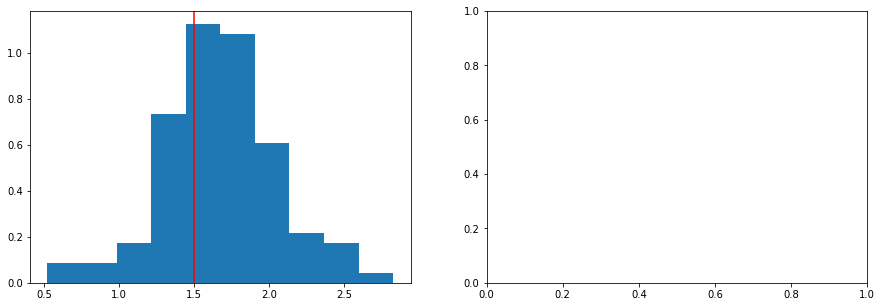

In [38]:
f,ax = plt.subplots(1,2,figsize = (15,5))
_= ax[0].hist(np.array(weighted_gmm)[:,0],density=True)#,range= (0.025,0.4)
ax[0].axvline(TRUE_ENVELOPE_PARAMS[0],c='red')
#_=ax[1].hist(np.array(weighted_gmm)[:,1],density=True) #range=(0,5),
#ax[1].axvline(TRUE_ENVELOPE_PARAMS[1],c='red')

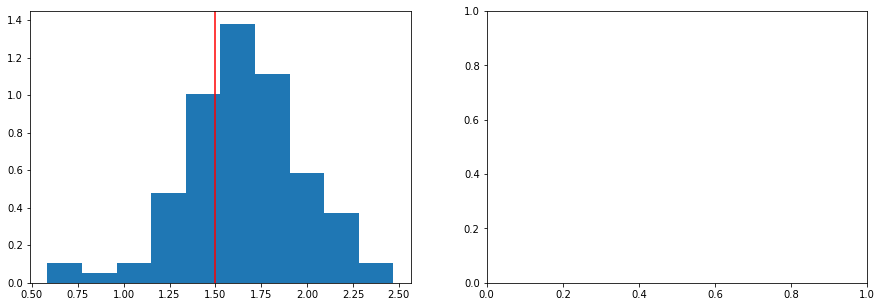

In [39]:
f,ax = plt.subplots(1,2,figsize = (15,5))
_=ax[0].hist(np.array(non_weighted_gmm)[:,0],density = True) #,range= (0.025,0.2)
ax[0].axvline(TRUE_ENVELOPE_PARAMS[0],c='red')
#_=ax[1].hist(np.array(non_weighted_gmm)[:,1],density=True)
#ax[1].axvline(TRUE_ENVELOPE_PARAMS[1],c='red')

values_to_use

In [40]:
np.mean(np.abs(np.array(non_weighted_gmm)- TRUE_ENVELOPE_PARAMS[0]),axis=0)

array([0.28055563])

In [41]:
np.mean(np.abs(np.array(weighted_gmm)- TRUE_ENVELOPE_PARAMS[0]),axis=0)

array([0.32729215])

In [42]:
((np.median(np.abs(np.array(weighted_gmm)- np.array(TRUE_ENVELOPE_PARAMS)[0]),axis=0) / np.median(np.abs(np.array(non_weighted_gmm)- np.array(TRUE_ENVELOPE_PARAMS[0])),axis=0)))

array([1.1516039])

In [43]:
TRUE_ENVELOPE_PARAMS

(1.5, 1.0)

In [ ]:
 corr_np(tau,envelope,np.array([1.]))

In [ ]:
corr_np

In [75]:
lags_list

((1, 3, 5, 15), (1, 3, 5, 10), (1, 3))

In [76]:
n_values

(1000, 500, 250, 150)

In [172]:
input_

'1'